In [494]:
import matplotlib.pyplot as plt
import numpy as np
from brainweb_dl import get_mri
import scipy
import pylops
import pyproximal
plt.rcParams["image.cmap"] = "gray"

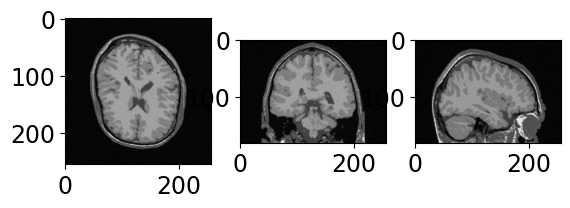

In [495]:
mri_data = get_mri(sub_id=43, contrast="T1")
mri_data = mri_data[::-1, ...]
fig, ax = plt.subplots(1, 3)
ax[0].imshow(mri_data[90, :, :])
ax[1].imshow(mri_data[:, 108, :])
ax[2].imshow(mri_data[:, :, 90])

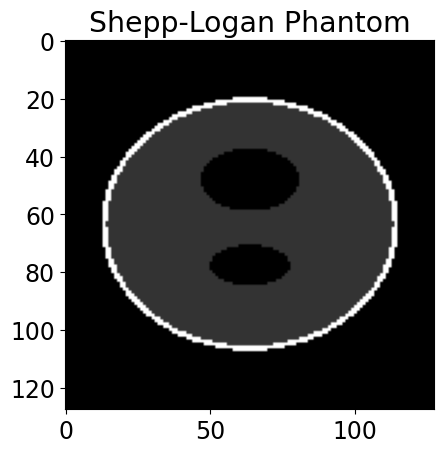

In [496]:
def phantom3d(*args):
    ellipse, n = parse_inputs(*args)
    p = np.zeros((n, n, n))
    rng = np.linspace(-1, 1, n)
    x, y, z = np.meshgrid(rng, rng, rng)
    coord = np.vstack((x.flatten(), y.flatten(), z.flatten()))
    p = p.flatten()
    for k in range(ellipse.shape[0]):
        A = ellipse[k, 0]            # Amplitude change for this ellipsoid
        asq = ellipse[k, 1] ** 2     # a^2
        bsq = ellipse[k, 2] ** 2     # b^2
        csq = ellipse[k, 3] ** 2     # c^2
        x0 = ellipse[k, 4]           # x offset
        y0 = ellipse[k, 5]           # y offset
        z0 = ellipse[k, 6]           # z offset
        phi = ellipse[k, 7] * np.pi / 180   # first Euler angle in radians
        theta = ellipse[k, 8] * np.pi / 180 # second Euler angle in radians
        psi = ellipse[k, 9] * np.pi / 180   # third Euler angle in radians
        cphi = np.cos(phi)
        sphi = np.sin(phi)
        ctheta = np.cos(theta)
        stheta = np.sin(theta)
        cpsi = np.cos(psi)
        spsi = np.sin(psi)
        # Euler rotation matrix
        alpha = np.array([[cpsi * cphi - ctheta * sphi * spsi, cpsi * sphi + ctheta * cphi * spsi, spsi * stheta],
                          [-spsi * cphi - ctheta * sphi * cpsi, -spsi * sphi + ctheta * cphi * cpsi, cpsi * stheta],
                          [stheta * sphi, -stheta * cphi, ctheta]])
        # rotated ellipsoid coordinates
        coordp = np.dot(alpha, coord)
        idx = np.where((coordp[0, :] - x0) ** 2 / asq + (coordp[1, :] - y0) ** 2 / bsq + (coordp[2, :] - z0) ** 2 / csq <= 1)[0]
        p[idx] += A
    p = p.reshape((n, n, n))
    return p, ellipse

def flatten(in_arr):
    return in_arr.flatten()

def parse_inputs(*args):
    n = 128  # Default size
    e = None
    defaults = ['shepp-logan', 'modified shepp-logan', 'yu-ye-wang']
    for i in range(len(args)):
        if isinstance(args[i], str):  # Look for a default phantom
            def_str = args[i].lower()
            idx = defaults.index(def_str) if def_str in defaults else None
            if idx is None:
                raise ValueError('Unknown default phantom selected.')
            if defaults[idx] == 'shepp-logan':
                e = shepp_logan()
            elif defaults[idx] == 'modified shepp-logan':
                e = modified_shepp_logan()
            elif defaults[idx] == 'yu-ye-wang':
                e = yu_ye_wang()
        elif isinstance(args[i], (int, float)):  # a scalar is the image size
            n = int(args[i])
        elif isinstance(args[i], np.ndarray) and args[i].ndim == 2 and args[i].shape[1] == 10:
            e = args[i]  # user specified phantom
        else:
            raise ValueError('Invalid input arguments.')
    if e is None:
        e = modified_shepp_logan()
    return e, n

# Default head phantoms

def shepp_logan():
    return modified_shepp_logan()

def modified_shepp_logan():
    return np.array([[1, 0.6900, 0.920, 0.810, 0, 0, 0, 0, 0, 0],
                     [-0.8, 0.6624, 0.874, 0.780, 0, -0.0184, 0, 0, 0, 0],
                     [-0.2, 0.1100, 0.310, 0.220, 0.22, 0, 0, -18, 0, 10],
                     [-0.2, 0.1600, 0.410, 0.280, -0.22, 0, 0, 18, 0, 10],
                     [0.1, 0.2100, 0.250, 0.410, 0, 0.35, -0.15, 0, 0, 0],
                     [0.1, 0.0460, 0.046, 0.050, 0, 0.1, 0.25, 0, 0, 0],
                     [0.1, 0.0460, 0.046, 0.050, 0, -0.1, 0.25, 0, 0, 0],
                     [0.1, 0.0460, 0.023, 0.050, -0.08, -0.605, 0, 0, 0, 0],
                     [0.1, 0.0230, 0.023, 0.020, 0, -0.606, 0, 0, 0, 0],
                     [0.1, 0.0230, 0.046, 0.020, 0.06, -0.605, 0, 0, 0, 0]])

def yu_ye_wang():
    return np.array([[1, 0.6900, 0.920, 0.900, 0, 0, 0, 0, 0, 0],
                     [-0.8, 0.6624, 0.874, 0.880, 0, 0, 0, 0, 0, 0],
                     [-0.2, 0.4100, 0.160, 0.210, -0.22, 0, -0.25, 108, 0, 0],
                     [-0.2, 0.3100, 0.110, 0.220, 0.22, 0, -0.25, 72, 0, 0],
                     [0.2, 0.2100, 0.250, 0.500, 0, 0.35, -0.25, 0, 0, 0],
                     [0.2, 0.0460, 0.046, 0.046, 0, 0.1, -0.25, 0, 0, 0],
                     [0.1, 0.0460, 0.023, 0.020, -0.08, -0.65, -0.25, 0, 0, 0],
                     [0.1, 0.0460, 0.023, 0.020, 0.06, -0.65, -0.25, 90, 0, 0],
                     [0.2, 0.0560, 0.040, 0.100, 0.06, -0.105, 0.625, 90, 0, 0],
                     [-0.2, 0.0560, 0.056, 0.100, 0, 0.100, 0.625, 0, 0, 0]])

# Example usage:

# Create a 3D phantom

p, e = phantom3d('shepp-logan', 128)
phantom = p[64, :, :]
# Display the 3D phantom
plt.figure()
plt.imshow(phantom, cmap='gray')
plt.title('Shepp-Logan Phantom')
plt.show()


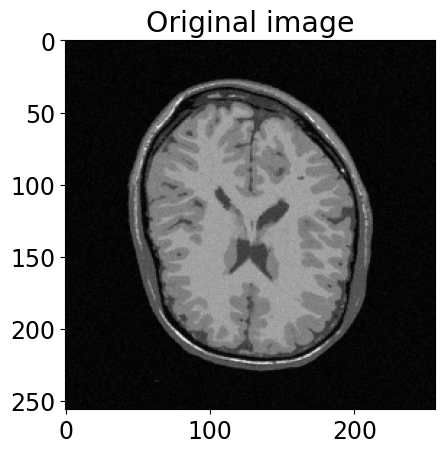

In [497]:
mri_image = mri_data[90, :, :]
plt.figure()
plt.imshow(mri_image)
plt.title("Original image")
plt.show()

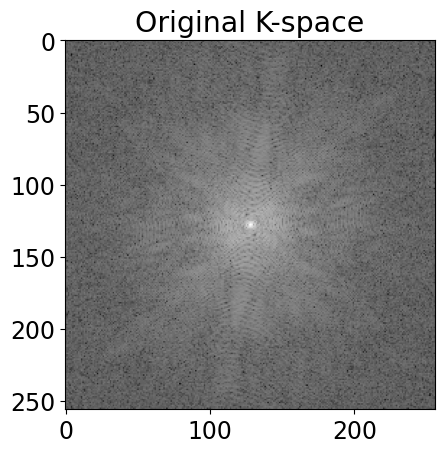

In [498]:
# transform the image into kspace

from scipy.fftpack import fftn

kspace = fftn(mri_image)
kspace = np.fft.fftshift(kspace)

plt.figure()
plt.title("Original K-space")
plt.imshow(np.log(np.abs(kspace)+1))
plt.show()

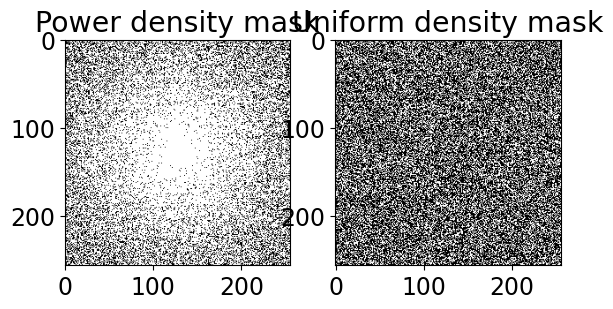

In [499]:
# Create a mask with a power distribution

def power_density_mask(kspace_shape):
    power_mask = np.zeros(kspace_shape, dtype=float)
    center_x, center_y = power_mask.shape[0] // 2, power_mask.shape[1] // 2
    max_radius = np.sqrt(center_x ** 2 + center_y ** 2)

    for i in range(power_mask.shape[0]):
        for j in range(power_mask.shape[1]):
            radius = np.sqrt((i - center_x) ** 2 + (j - center_y) ** 2)/max_radius
            # give a 1 or 0 with probability
            power_mask[i, j] = np.random.rand() < (1/(1+radius**1.8))

    return power_mask

def uniform_density_mask(kspace_shape):
    # create a mask with a unifrom distribution
    uniform_mask = np.zeros(kspace_shape, dtype=float)
    for i in range(uniform_mask.shape[0]):
        for j in range(uniform_mask.shape[1]):
            uniform_mask[i, j] = np.random.rand() < 0.40
    return uniform_mask

power_mask = power_density_mask(kspace.shape)
uniform_mask = uniform_density_mask(kspace.shape)
# plot the masks
plt.figure()
plt.subplot(121)
plt.title("Power density mask")
plt.imshow(power_mask)
plt.subplot(122)
plt.title("Uniform density mask")
plt.imshow(uniform_mask)
plt.show()


In [541]:
# writing of the optimisiation problem

# setting the variables

image = phantom
kspace = np.fft.fftshift(np.fft.fft2(image))
mask = power_density_mask(kspace.shape)
undersampled_kspace = kspace * mask

y = undersampled_kspace

def f(x):
    return 0.5 * np.linalg.norm(mask*(np.fft.fftshift(np.fft.fft2(x)) - y)) ** 2

def l1(x):
    return np.linalg.norm(x, 1)

def tv(x):
    # return the total variation norm of x
    return np.linalg.norm(np.gradient(x), 1)

def grad_f(x):
    fftx = np.fft.fftshift(np.fft.fft2(x))
    return np.fft.ifft2(mask*fftx - y).real

def prox_g(x, gamma):
    r"""
    Calcule l'opérateur proximal associé à \gamma g.
    Args:
    - x (np.array): L'argument du proximal.
    - gamma (float): La constante gamma.
    """
    return np.sign(x) * np.maximum(np.abs(x) - gamma, 0)

# I want the prox related the the total variation norm

def prox_tv(x, gamma):
    r"""
    Calcule l'opérateur proximal associé à \gamma ||\nabla x||_1.
    Args:
    - x (np.array): L'argument du proximal.
    - gamma (float): La constante gamma.
    """
    return pyproximal.TV(dims=x.shape)(x)

# Lipscitiz constant of the grad_f
n = kspace.shape[0]
Lip = n
lambd = 1/n # we need lip*lambd<2 so that ISTA converge

# ISTA iterations

n_iter = 20
x0 = np.fft.ifft2(y).real

xk = x0
for iter in range(n_iter):

    xk = prox_g(xk - lambd*grad_f(xk), lambd)
    cost = f(xk)+ g(xk)
    print(f"Iteration {iter+1}, Cost: {cost}")


x_recon = xk

Iteration 1, Cost: 9942080.325239025
Iteration 2, Cost: 9906342.962706495
Iteration 3, Cost: 9876472.587230345
Iteration 4, Cost: 9852033.902980983
Iteration 5, Cost: 9831648.357672922
Iteration 6, Cost: 9814955.59844977
Iteration 7, Cost: 9801290.771745736
Iteration 8, Cost: 9790512.641340993
Iteration 9, Cost: 9782692.311436225
Iteration 10, Cost: 9777811.462653525
Iteration 11, Cost: 9775674.282947721
Iteration 12, Cost: 9775992.224007707
Iteration 13, Cost: 9778742.875226753
Iteration 14, Cost: 9783889.846041821
Iteration 15, Cost: 9791377.330988584
Iteration 16, Cost: 9801046.725484768
Iteration 17, Cost: 9812856.55752631
Iteration 18, Cost: 9826846.428240255
Iteration 19, Cost: 9842746.424522959
Iteration 20, Cost: 9860230.989903696


In [501]:
import numpy as np
import scipy.sparse
from sklearn.linear_model import Lasso

def reconstruct_mri_lasso(sample_matrix_kspace, image, sparsity_coef=0.03):
    """
    Reconstruct MRI image using sklearn LASSO (Least Absolute Shrinkage and Selection Operator) algorithm.

    Parameters:
        sample_matrix (ndarray): Binary matrix indicating the sampled k-space points.
        kspace (ndarray): The undersampled k-space data.
        sparsity_coef (float): Sparsity coefficient controlling the level of sparsity in the reconstruction.

    Returns:
        ndarray: Reconstructed MRI image.
    """

    kspace = np.fft.fftshift(np.fft.fftn(image))
    # Calculate shape of k-space
    kspace_shape = kspace.shape

    # Apply sampling mask to k-space
    undersampled_kspace = sample_matrix_kspace * kspace

    # Constructing the design matrix and target vector for sklearn LASSO
    X = scipy.sparse.diags(sample_matrix_kspace.ravel(), 0)
    y = undersampled_kspace.ravel()


    # Fit LASSO model for real and imaginary parts separately
    Lasso_real = Lasso(alpha=sparsity_coef)
    Lasso_imag = Lasso(alpha=sparsity_coef)

    y_real = np.real(y)
    y_imag = np.imag(y)

    Lasso_real.fit(X, y_real)
    Lasso_imag.fit(X, y_imag)

    # Reconstruct real and imaginary parts of the image
    Tf_X_recon_real = Lasso_real.coef_.reshape(kspace_shape)
    Tf_X_recon_imag = Lasso_imag.coef_.reshape(kspace_shape)

    # Combine real and imaginary parts to form the complex-valued image
    Tf_X_recon = Tf_X_recon_real + 1j * Tf_X_recon_imag

    # Inverse Fourier transform to get the reconstructed image
    reconstructed_image = np.fft.ifftn(Tf_X_recon)

    return reconstructed_image


In [502]:
import torch
import deepinv as dinv
from deepinv.optim import L1, L2, TVPrior
from deepinv.optim import WaveletPrior
from deepinv.optim.prior import Prior
from torch.fft import fft
from deepinv.optim import DataFidelity
from deepinv.utils.plotting import plot


In [503]:
class MRI_fidelity(DataFidelity):
    def __init__(self, y=0, physics=None):
        super().__init__()
        self.y = y
        self.physics = physics

    def d(self, x):
        r"""
        Computes the data fidelity distance :math:`\datafid{u}{y}`, i.e.

        .. math::

            \datafid{u}{y} = \frac{1}{2\sigma^2}\|u-y\|^2


        :param torch.Tensor u: Variable :math:`u` at which the data fidelity is computed.
        :param torch.Tensor y: Data :math:`y`.
        :return: (torch.Tensor) data fidelity :math:`\datafid{u}{y}` of size `B` with `B` the size of the batch.
        """
        diff_y= self.physics(torch.fft.fft2(x) - self.y)
        d = 0.5 * torch.norm(diff_y.view(diff_y.shape[0], -1), p=2, dim=-1) ** 2
        return  d

    def grad(self, x):

        grad = torch.fft.fft2(self.physics(torch.fft.fft2(x) - self.y)).real
        return grad


In [504]:

kspace_phantom = np.fft.fftshift(np.fft.fftn(phantom))
power_mask = power_density_mask(kspace_phantom.shape)
undersampled_kspace = kspace_phantom * power_mask

x = torch.from_numpy(kspace_phantom)

mask = torch.from_numpy(power_mask)

physics = dinv.physics.Inpainting(mask=mask, tensor_size=mask.shape[1:])

y = physics(x).unsqueeze(0)

print(y.shape)

torch.Size([1, 1, 128, 128])


torch.Size([128, 128])


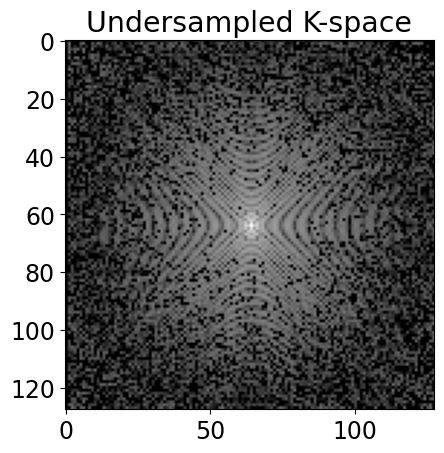

In [505]:
y_image = y.squeeze()
print(y_image.shape)

# show y
plt.figure()
plt.imshow(np.log(np.abs(y_image)+1))
plt.title("Undersampled K-space")
plt.show()


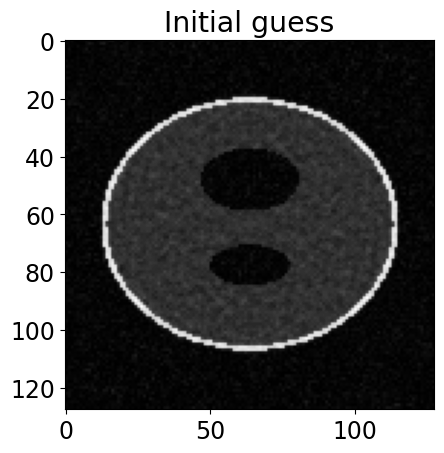

tensor([1.1659e+08], dtype=torch.float64)
tensor([6.5309e+11], dtype=torch.float64)
tensor([5.6612e+15], dtype=torch.float64)
tensor([7.2151e+19], dtype=torch.float64)
tensor([1.0980e+24], dtype=torch.float64)
tensor([1.7653e+28], dtype=torch.float64)
tensor([2.8802e+32], dtype=torch.float64)
tensor([4.7177e+36], dtype=torch.float64)
tensor([7.7366e+40], dtype=torch.float64)
tensor([1.2693e+45], dtype=torch.float64)
tensor([2.0832e+49], dtype=torch.float64)
tensor([3.4197e+53], dtype=torch.float64)
tensor([5.6151e+57], dtype=torch.float64)
tensor([9.2222e+61], dtype=torch.float64)
tensor([1.5150e+66], dtype=torch.float64)
tensor([2.4894e+70], dtype=torch.float64)
tensor([4.0914e+74], dtype=torch.float64)
tensor([6.7259e+78], dtype=torch.float64)
tensor([1.1059e+83], dtype=torch.float64)
tensor([1.8189e+87], dtype=torch.float64)
tensor([2.9923e+91], dtype=torch.float64)
tensor([4.9236e+95], dtype=torch.float64)
tensor([8.1032e+99], dtype=torch.float64)
tensor([1.3339e+104], dtype=torch.

In [506]:
data_fidelity = MRI_fidelity(y=y, physics=physics)
prior = dinv.optim.L1Prior()

# The gradient have a lipischitz constant equal to n
n = y.squeeze().shape[0]

lambd = 1/n # to ensure the convergence we need to have lambd < 2/L where L is the lipischitz constant of the gradient

# PGD algorithm
max_iter = 200 # number of iterations

x_k = torch.fft.ifft2(y).real # initial guess

# show the image x_k with plt
plt.figure()
plt.imshow(np.abs(x_k.squeeze()))
plt.title("Initial guess")
plt.show()

eps = 1  # Tolerance for the cost function

for iter in range(max_iter):
    x_k = x_k - lambd * data_fidelity.grad(x_k)
    x_k = prior.prox(x_k, lambd)
    cost = data_fidelity.d(x_k) + prior(x_k)
    print(cost)

torch.Size([1, 1, 128, 128])
(128, 128)


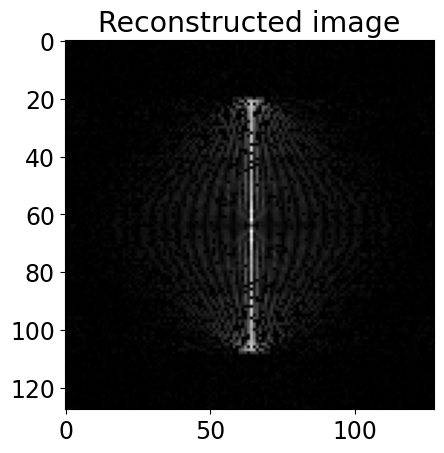

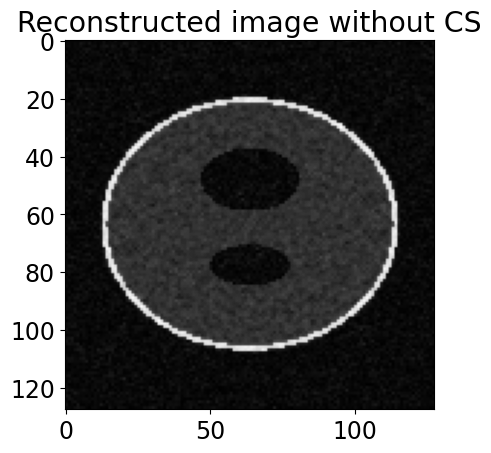

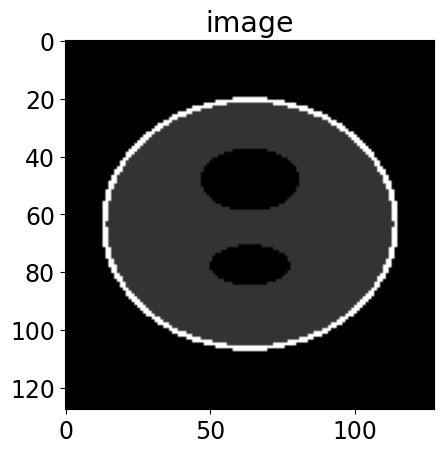

MSE of the reconstructed image with CS: 9.467718463877699e+164
MSE of the reconstructed image without CS: 0.002073398888919975


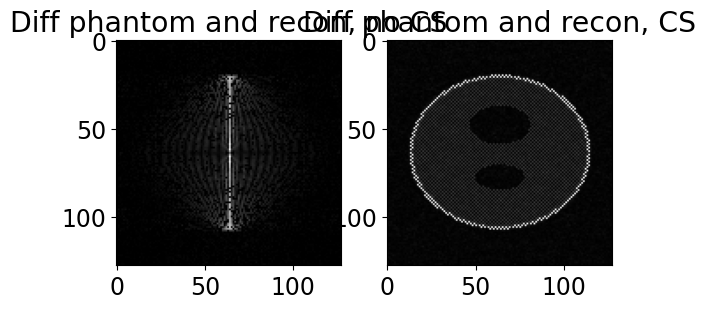

In [404]:
print(x_k.shape)
reconstructed_kspace = x_k.detach().numpy().squeeze()
print(reconstructed_kspace.shape)

# create an image 4 times the size of the original image to make it periodic
reconstructed_kspace = np.fft.ifftshift(reconstructed_kspace)

reconstructed_image = np.fft.ifftn(reconstructed_kspace)

plt.figure()
plt.imshow(np.abs(reconstructed_image))
plt.title("Reconstructed image")
plt.show()

recon_image = np.fft.ifftn(undersampled_kspace)
plt.figure()
plt.imshow(np.abs(recon_image))
plt.title("Reconstructed image without CS")
plt.show()


plt.figure()
plt.imshow(np.abs(phantom))
plt.title("image")
plt.show()

mse_CS = np.mean((np.abs(phantom) - np.abs(reconstructed_image)) ** 2)
print("MSE of the reconstructed image with CS:", mse_CS)
mse = np.mean((np.abs(phantom) - np.abs(recon_image)) ** 2)
print("MSE of the reconstructed image without CS:", mse)

# plot the difference between the phantom and the reconstructed image and the phantom and the recon_image side by side withe the MSE in the plot

plt.figure()
plt.subplot(121)
plt.imshow(np.abs(phantom - reconstructed_image))
plt.title("Diff phantom and recon, no CS")
plt.subplot(122)
plt.imshow(np.abs(phantom - recon_image))
plt.title("Diff phantom and recon, CS")
plt.show()


In [ ]:
shape_phatom_image = phatom_image.shape

power_mask = power_density_mask(shape_phatom_image)

recon_phantom_lasso = reconstruct_mri_lasso(power_mask, phatom_image)

kspace_phantom = np.fft.fftshift(np.fft.fftn(phatom_image))
undersampled_kspace = power_mask * kspace_phantom
recon_phantom = np.fft.ifftn(undersampled_kspace)


# plot the two recon and the original

plt.figure()
plt.subplot(131)
plt.title("Original phantom")
plt.imshow(phatom_image)
plt.subplot(132)
plt.title("Reconstructed phantom")
plt.imshow(np.abs(recon_phantom_lasso))
plt.subplot(133)
plt.title("Reconstructed phantom")
plt.imshow(np.abs(recon_phantom))
plt.show()


In [ ]:
plt.show()

reconstructed_image = reconstruct_mri_lasso(power_density_mask, kspace)
plt.figure()
plt.imshow(np.abs(reconstructed_image))
plt.title("Reconstructed image")
plt.show()


In [ ]:
absolute_diff_image_1 = np.abs(original_img - np.abs(reconstructed_image))
plt.figure()
plt.imshow(absolute_diff_image_1)
plt.title("Absolute difference image")
plt.show()

absolute_diff_image_2 = np.abs(original_img - np.abs(image))
plt.figure()
plt.imshow(absolute_diff_image_2)
plt.title("Absolute difference image")
plt.show()


In [ ]:
# show image

recon_power_density_cs = reconstruct_mri_lasso(power_density_mask, kspace)

recon_power_density = np.fft.ifft(power_density_mask * kspace)

# print the recon_image with cs and no cs and the original image side by side
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(np.abs(recon_power_density_cs))
plt.title("Reconstructed image with CS")
plt.subplot(132)
plt.imshow(np.abs(recon_power_density))
plt.title("Reconstructed image without CS")
plt.subplot(133)
plt.imshow(np.abs(img))
plt.title("Original image")
plt.show()


In [ ]:
# print the recon image and the original image side by side
plt.figure()
plt.subplot(121)
plt.title("Reconstructed image")
plt.imshow(np.abs(image_recon))
plt.subplot(122)
plt.title("Original image")
plt.imshow(np.abs(img))
plt.show()


In [ ]:

y = kspace_undersampled_power.ravel()
y_real = np.real(y)
y_imag = np.imag(y)
mask = power_density_mask.ravel()
# create a diagonal matrix with the mask
X = scipy.sparse.diags(mask, 0)

from sklearn import linear_model
Lasso_real = linear_model.Lasso(alpha=0.03)
Lasso_imag = linear_model.Lasso(alpha=0.03)

Lasso_real.fit(X, y_real)
Lasso_imag.fit(X, y_imag)

In [ ]:
shape = kspace.shape

Tf_X_recon_real = Lasso_real.coef_.reshape(shape)
Tf_X_recon_imag = Lasso_imag.coef_.reshape(shape)

Tf_X_recon = Tf_X_recon_real + 1j * Tf_X_recon_imag

In [ ]:
recon_image = np.fft.ifftn(Tf_X_recon)

# print the recon image and the original image side by side
plt.figure()
plt.subplot(121)
plt.title("Reconstructed image")
plt.imshow(np.abs(recon_image))
plt.subplot(122)
plt.title("Original image")
plt.imshow(np.abs(img))
plt.show()
